In [242]:
import numpy as np

In [243]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter=None, lr=None, kernel='linear', threshold=1e-5, verbose=False, random_state=None, gamma=1, theta=0, d=1):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.random_state = random_state
        self.gamma = gamma
        self.theta = theta
        self.d = d

    def _init_lambda(self, higher, size):
        np.random.seed(self.random_state)
        return np.random.uniform(0, higher, size)

    def _linear_kernel(self, X_i, X_j):
        return X_i @ X_j.T
    
    def _poly_kernel(self, X_i, X_j):
        return (self.gamma * self._linear_kernel(X_i, X_j) + self.theta)**self.d

    def _kernel_chooser(self, X_i, X_j):
        if (self.kernel == 'linear'):
            return self._linear_kernel(X_i, X_j)
        elif (self.kernel == 'poly'):
            return self._poly_kernel(X_i, X_j)
        else:
            raise Exception('Invalid kernel')

    def _Lagrange_sum(self, X, y, _lambda):
        s = np.zeros(y.shape[0])
        for i in range(0, y.shape[0]):
            for j in range(0, y.shape[0]):
                s[i] = s[i] + _lambda[j] * y[j] * self._kernel_chooser(X[i, :], X[j, :])
        return s

    def _diff(self, X, y, _lambda):
        return 1 - y * self._Lagrange_sum(X, y, _lambda)

    def _gradient_ascent(self, X, y):
        _lambda = self._init_lambda(10, y.shape[0])
        for i in range(0, self.iter):
            _lambda = _lambda + self.lr * self._diff(X, y, _lambda)
            _lambda[_lambda < 0] = 0
        return _lambda

    def _determine_support_vectors(self, X, y):
        _lambda = self._gradient_ascent(X, y)
        idx = np.where(_lambda > self.threshold)
        return idx, X[idx], y[idx], _lambda[idx]

    def load_fitted_parameters(self, sup_lambda, sup_vectors_label, support_vectors_):
        self.sup_lambda = sup_lambda
        self.sup_vectors_label = sup_vectors_label
        self.support_vectors_ = support_vectors_

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : 次の形のndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        self._y_unique = np.unique(y)
        y = np.where(y == self._y_unique[0], -1, 1)

        if self.verbose:
            #Output the learning process when verbose is set to True print()
            print("training set: fitting...")
            self.support_, self.support_vectors_, self.sup_vectors_label, self.sup_lambda = self._determine_support_vectors(X, y)
            if ((X_val is not None) and (y_val is not None)):
                print("test set: fitting...")
                self.support_val, self.support_vectors_val, self.sup_vectors_label_val, self.sup_lambda_val = self._determine_support_vectors(X_val, y_val)

        else:
            self.support_, self.support_vectors_, self.sup_vectors_label, self.sup_lambda = self._determine_support_vectors(X, y)
            if ((X_val is not None) and (y_val is not None)):
                self.support_val, self.support_vectors_val, self.sup_vectors_label_val, self.sup_lambda_val = self._determine_support_vectors(X_val, y_val)

    def predict(self, X):
        """
        Estimate the label using the SVM classifier.
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
        result = np.zeros(X.shape[0])
        for n in range(0, self.sup_lambda.shape[0]):
            result += self.sup_lambda[n] * self.sup_vectors_label[n] * self._kernel_chooser(X, self.support_vectors_[n])
        
        result = np.where(result < 0, self._y_unique[0], self._y_unique[1])
        return result

<h3>【problem 4】Learning and estimation</h3>

In [244]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

<h4>Dataset 1</h4>

In [245]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

(375, 2)
(125, 2)
(375,)
(125,)


In [247]:
def compute_score(y_pred, y):
    print("y: {}".format(y))
    print("y_pred: {}\n".format(y_pred))
    print("Accuracy: {}".format(metrics.accuracy_score(y_pred=y_pred, y_true=y)))
    print("Precision: {}".format(metrics.precision_score(y_pred=y_pred, y_true=y)))
    print("Recall: {}".format(metrics.recall_score(y_pred=y_pred, y_true=y)))
    print("F1: {}".format(metrics.f1_score(y_pred=y_pred, y_true=y)))

<h4>Scratch training</h4>

In [248]:
svm_scratch = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5, verbose=True, random_state=0)
svm_scratch.fit(X_train_std, y_train, X_test_std, y_test)
y_pred = svm_scratch.predict(X_test_std)

for i in range(0, svm_scratch.support_[0].shape[0]):
    print("idx: {}      sup_vector: {}".format(svm_scratch.support_[0][i], svm_scratch.support_vectors_[i]))

compute_score(y_pred, y_test)

training set: fitting...
test set: fitting...
idx: 70      sup_vector: [ 0.85185871 -0.34303918]
idx: 94      sup_vector: [-0.94045143 -0.10488777]
idx: 158      sup_vector: [1.13987583 0.25288687]
idx: 175      sup_vector: [-0.96845046 -0.16251457]
idx: 359      sup_vector: [ 0.98179341 -0.14716867]
idx: 361      sup_vector: [ 0.23125565 -0.60352876]
y: [-1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1
  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1  1 -1
  1  1 -1  1  1]
y_pred: [-1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1
  1  1 -1 -1  1 -1  1 -1  1 -1 -1 

Save parameters

In [250]:
np.savez(
    'svm_fitted_para.npz',
    support_=svm_scratch.support_,
    support_vectors_=svm_scratch.support_vectors_,
    sup_vectors_label=svm_scratch.sup_vectors_label,
    sup_lambda=svm_scratch.sup_lambda
    )

In [251]:
npzfile = np.load('svm_fitted_para.npz')
sorted(npzfile)

['sup_lambda', 'sup_vectors_label', 'support_', 'support_vectors_']

<h4>Sklearn training</h4>

In [252]:
from sklearn.svm import SVC

In [255]:
svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train_std, y_train)
y_pred = svm_sklearn.predict(X_test_std)

for i in range(0, svm_sklearn.support_.shape[0]):
    print("idx: {}      sup_vector: {}".format(svm_sklearn.support_[i], svm_sklearn.support_vectors_[i]))

compute_score(y_pred, y_test)

idx: 78      sup_vector: [ 0.33150479 -0.41574868]
idx: 358      sup_vector: [-0.16300339 -0.9951522 ]
idx: 56      sup_vector: [-0.21304083  0.7718636 ]
idx: 94      sup_vector: [-0.94045143 -0.10488777]
idx: 175      sup_vector: [-0.96845046 -0.16251457]
y: [-1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1
  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1  1 -1
  1  1 -1  1  1]
y_pred: [-1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1
  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 

<h3>【problem5】Visualization of decision area</h3>

In [187]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [256]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'], support_vectors=False):
    """
    Draw the determination area of the model that learned binary classification with two-dimensional features.
    The background color is drawn from the estimated values of the trained model.
    The points on the scatter plot are training or validation data.
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        Feature value
    y : ndarray, shape(n_samples,)
        label
    model : object
        Insert the installed model of the learned model
    step : float, (default : 0.1)
        Set the interval to calculate the estimate
    title : str
        Give the text of the graph Title
    xlabel, ylabel : str
        Give the text of the axis label
    target_names= : list of str
        Give a list of legends
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    if (support_vectors == True):
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], color='yellow')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

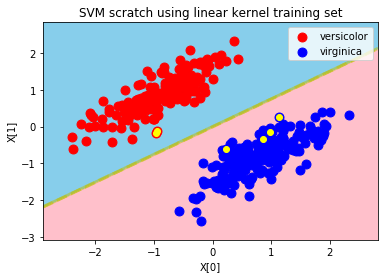

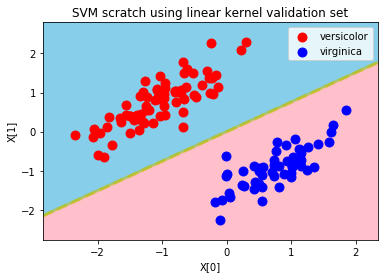

In [259]:
decision_region(
    X_train_std, 
    y_train, 
    svm_scratch, 
    title="SVM scratch using linear kernel training set", 
    xlabel="X[0]", 
    ylabel="X[1]",
    support_vectors=True
)

decision_region(
    X_test_std, 
    y_test, 
    svm_scratch, 
    title="SVM scratch using linear kernel validation set", 
    xlabel="X[0]", 
    ylabel="X[1]"
)

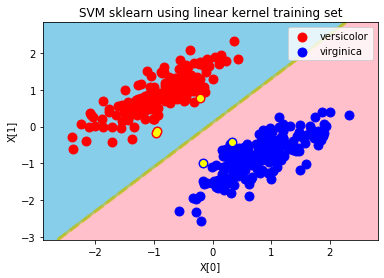

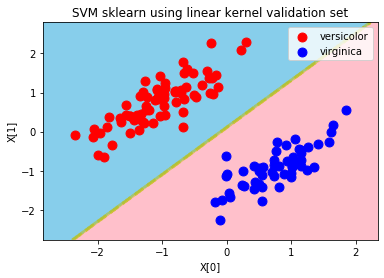

In [260]:
decision_region(
    X_train_std, 
    y_train, 
    svm_sklearn, 
    title="SVM sklearn using linear kernel training set", 
    xlabel="X[0]", 
    ylabel="X[1]",
    support_vectors=True
)

decision_region(
    X_test_std, 
    y_test, 
    svm_sklearn, 
    title="SVM sklearn using linear kernel validation set", 
    xlabel="X[0]", 
    ylabel="X[1]"
)

<h3>【problem 6】(Advance task) Creation of polynomial kernel function</h3>

<h4>Scratch test</h4>

In [261]:
svm_scratch_poly = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='poly', threshold=1e-5, verbose=True, random_state=0, gamma=1/X_train_std.shape[1], theta=X_train_std.shape[1], d=3)
svm_scratch_poly.fit(X_train_std, y_train, X_test_std, y_test)
y_pred = svm_scratch_poly.predict(X_test_std)

for i in range(0, svm_scratch_poly.support_[0].shape[0]):
    print("idx: {}      sup_vector: {}".format(svm_scratch_poly.support_[0][i], svm_scratch_poly.support_vectors_[i]))

compute_score(y_pred, y_test)

training set: fitting...
test set: fitting...
idx: 54      sup_vector: [-0.31027234  0.68291078]
idx: 56      sup_vector: [-0.21304083  0.7718636 ]
idx: 71      sup_vector: [ 0.29562123 -0.46601178]
idx: 78      sup_vector: [ 0.33150479 -0.41574868]
idx: 94      sup_vector: [-0.94045143 -0.10488777]
idx: 158      sup_vector: [1.13987583 0.25288687]
idx: 175      sup_vector: [-0.96845046 -0.16251457]
idx: 361      sup_vector: [ 0.23125565 -0.60352876]
y: [-1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1
  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1  1 -1
  1  1 -1  1  1]
y_pred: [-1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1 -1
  1  1

<h4>Sklearn test</h4>

In [262]:
svm_sklearn_poly = SVC(kernel='poly', gamma='auto', degree=3)
svm_sklearn_poly.fit(X_train_std, y_train)
y_pred = svm_sklearn_poly.predict(X_test_std)

for i in range(0, svm_sklearn_poly.support_.shape[0]):
    print("idx: {}      sup_vector: {}".format(svm_sklearn_poly.support_[i], svm_sklearn_poly.support_vectors_[i]))

compute_score(y_pred, y_test)

idx: 48      sup_vector: [ 0.45032156 -0.5849564 ]
idx: 71      sup_vector: [ 0.29562123 -0.46601178]
idx: 75      sup_vector: [ 0.34084666 -0.65785372]
idx: 78      sup_vector: [ 0.33150479 -0.41574868]
idx: 144      sup_vector: [ 0.59517503 -0.45891081]
idx: 182      sup_vector: [ 0.19491573 -0.7940949 ]
idx: 248      sup_vector: [ 0.33356784 -0.74864426]
idx: 249      sup_vector: [ 0.54101664 -0.56615297]
idx: 256      sup_vector: [ 0.86657543 -0.08107166]
idx: 267      sup_vector: [ 0.16371435 -0.63750359]
idx: 340      sup_vector: [ 0.1770675  -0.79779121]
idx: 347      sup_vector: [ 0.79337069 -0.20376922]
idx: 353      sup_vector: [ 0.27417484 -0.69877862]
idx: 358      sup_vector: [-0.16300339 -0.9951522 ]
idx: 361      sup_vector: [ 0.23125565 -0.60352876]
idx: 15      sup_vector: [-0.72361978  0.63768245]
idx: 43      sup_vector: [-1.01648709  0.20375313]
idx: 50      sup_vector: [-0.12583628  0.94454634]
idx: 54      sup_vector: [-0.31027234  0.68291078]
idx: 56      sup_vec

<h4>Dicision regions</h4>

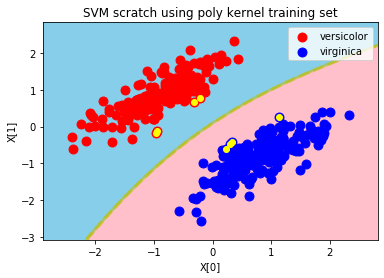

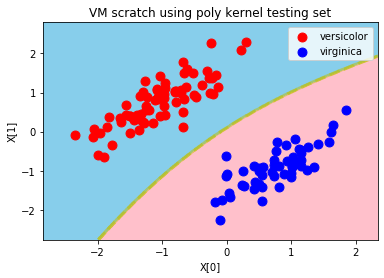

In [264]:
decision_region(
    X_train_std, 
    y_train, 
    svm_scratch_poly, 
    title="SVM scratch using poly kernel training set", 
    xlabel="X[0]", 
    ylabel="X[1]",
    support_vectors=True
)

decision_region(
    X_test_std, 
    y_test, 
    svm_scratch_poly, 
    title="VM scratch using poly kernel testing set", 
    xlabel="X[0]", 
    ylabel="X[1]"
)

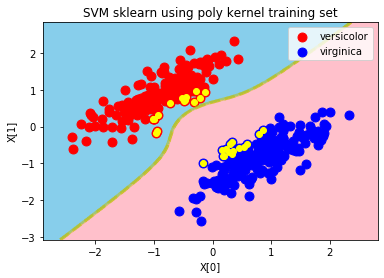

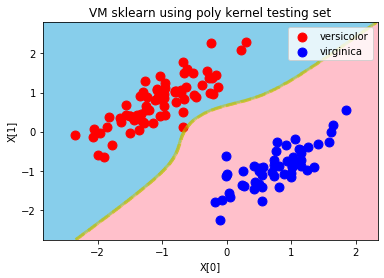

In [266]:
decision_region(
    X_train_std, 
    y_train, 
    svm_sklearn_poly, 
    title="SVM sklearn using poly kernel training set", 
    xlabel="X[0]", 
    ylabel="X[1]",
    support_vectors=True
)

decision_region(
    X_test_std, 
    y_test, 
    svm_sklearn_poly, 
    title="VM sklearn using poly kernel testing set", 
    xlabel="X[0]", 
    ylabel="X[1]"
)